<img src="https://wp.kntu.ac.ir/a.izadi/kntu-logo.png">

# Digital Image Processing
## 4th Computer Assignment
### Amirhosein Najafi (I)
### Student ID : 40112894
### Professor : Dr. Abrishami (II)

#### I : a.najafi@email.kntu.ac.ir
#### II : moghadam@eetd.kntu.ac.ir

<hr>

### Part I. Image Obliteration

#### I. Blurred Image

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from scipy import fftpack, signal


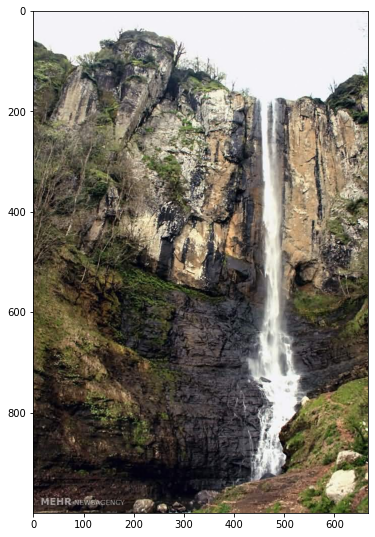

In [37]:
image = cv2.imread('Iran_Gilan_Laton_Waterfall.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 10))
plt.imshow(image)
plt.show()

In [38]:
def motion_blur_filter(length, angle):
    size = length
    motion_filter = np.zeros((size, size))
    
    angle = np.deg2rad(angle)
    
    center = int(np.floor(size / 2))
    
    for i in range(length):
        motion_filter[i, int(center + i * np.tan(angle))] = 1

    
    motion_filter /= motion_filter.sum()
    
    return motion_filter

In [39]:
def scale_images(image):
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    return normalized_image.astype(np.uint8)

In [40]:
def convolve_fft_channel(channel, filter_kernel):
    channel_fft = fftpack.fft2(channel)
    filter_fft = fftpack.fft2(filter_kernel, shape=channel.shape)

    return fftpack.ifft2(channel_fft * filter_fft).real

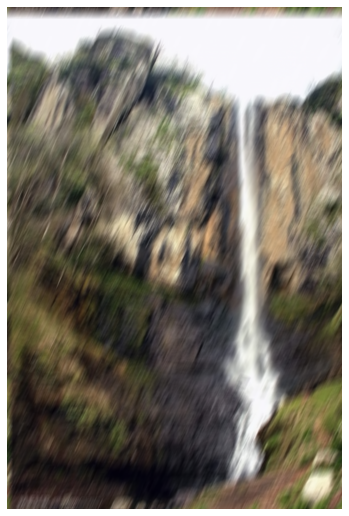

In [41]:
length = 25
angle = -25

motion_filter = motion_blur_filter(length, angle)

blurred_image = np.zeros_like(image)
for i in range(3):
    blurred_image[:, :, i] = convolve_fft_channel(image[:, :, i], motion_filter)

blurred_image = scale_images(blurred_image)

plt.figure(figsize=(6, 10))
plt.imshow(blurred_image)
plt.axis('off')
plt.show()

**Description**: First, we read the Lena image. Then, we define a motion_blur_filter function that returns a specific motion filter, given the angle and length of the filter. Upon applying this filter to the image, we observe that some blurring appears in the image.

#### II. Noisy Image

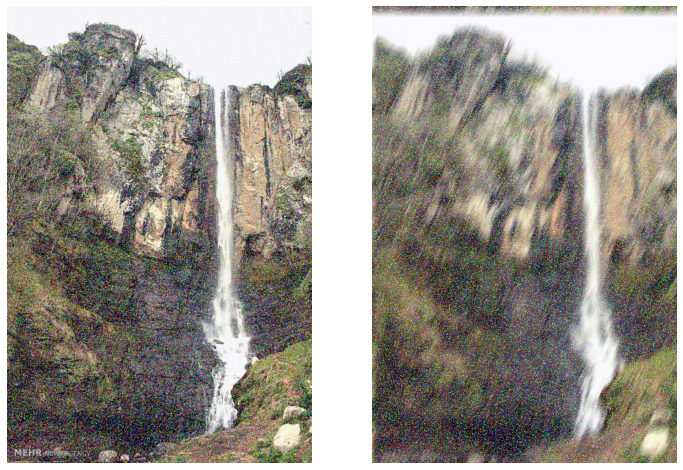

In [42]:
# 0.2 of variance was too low for this image so I canged it to 1

normal_noise = np.random.normal(0, 1, image.shape).astype(np.uint8)

noisy_image = cv2.add(image, normal_noise)

noisy_blured_image = cv2.add(blurred_image, normal_noise)


plt.figure(figsize=(12, 10))
plt.axis('off')

plt.subplot(1,2,1)
plt.imshow(noisy_image)
plt.axis('off')

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(noisy_blured_image)

**Description**: In this section, we first generate random normal noise with a mean of 0 and a variance of 1. Although the assignment specifies that the variance should be 0.2, this value seemed too low, so it was adjusted to 1. Subsequently, by adding this noise to both the original and blurred image, we can observe the results as shown above.

### Part II. Image Restoration

#### I. Noiseless Blurred Image Inverse Filtering

In [49]:
def inverseFiltering(blurred_image, motion_filter):
    # Extract color channels
    bb = blurred_image[:, :, 0]
    bg = blurred_image[:, :, 1]
    br = blurred_image[:, :, 2]

    # Center the motion filter
    mf = np.zeros(bb.shape)
    mf[:motion_filter.shape[0], :motion_filter.shape[1]] = motion_filter

    # Center the filter before Fourier transform
#     mf = np.fft.ifftshift(mf)

    MF = np.fft.fft2(mf)

    # FFT of blurred channels
    BBF = np.fft.fft2(bb)
    BGF = np.fft.fft2(bg)
    BRF = np.fft.fft2(br)

    # FFT of motion filter
    MF = np.fft.fft2(mf)

    # Avoid division by near-zero values
    epsilon = 1e-2
    MF[np.abs(MF) < epsilon] = epsilon

    # Inverse filtering
    FBF = BBF / MF
    FGF = BGF / MF
    FRF = BRF / MF

    # Inverse FFT and clipping
    fb = np.clip(np.abs(np.fft.ifft2(FBF)), 0, 255)
    fg = np.clip(np.abs(np.fft.ifft2(FGF)), 0, 255)
    fr = np.clip(np.abs(np.fft.ifft2(FRF)), 0, 255)

    # Combine channels
    inversed_filter_result = np.stack([fb, fg, fr], axis=-1).astype(np.uint8)

    return inversed_filter_result

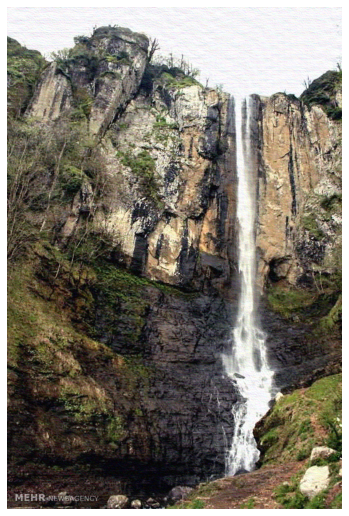

In [51]:
de_blured = inverseFiltering(blurred_image, motion_filter)

plt.figure(figsize=(6, 10))
plt.imshow(de_blured)
plt.axis('off')

plt.show()

#### II. Noised Blurred Image Inverse / Winner Filtering 

In [52]:
def wiener_filter(blured_image, kernel, K=10):

    kernel = np.pad(kernel, [(0, blured_image.shape[0] - kernel.shape[0]), (0, blured_image.shape[1] - kernel.shape[1])], 'constant')
    
    img = np.float32(blured_image)
    
    dummy = np.fft.fft2(img)
    kernel = np.fft.fft2(kernel)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    
    dummy = dummy * kernel
    dummy = np.abs(np.fft.ifft2(dummy))
    
    return np.uint8(dummy)

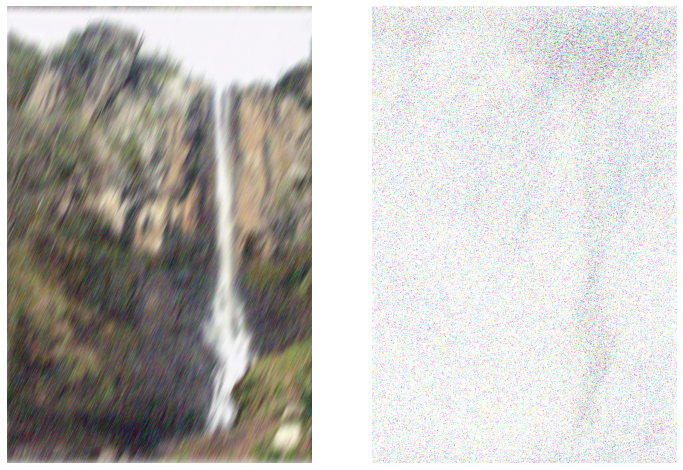

In [54]:
k = 2

de_blured_noisy = inverseFiltering(noisy_blured_image, motion_filter)


de_blured_noisy2 = np.zeros_like(image)
for i in range(3):
    de_blured_noisy2[:, :, i] = wiener_filter(noisy_blured_image[:, :, i], motion_filter, k)
    
de_blured_noisy2 = scale_images(de_blured_noisy2)

    
plt.figure(figsize=(12, 10))

plt.subplot(1,2,1)
plt.axis('off')

plt.imshow(de_blured_noisy2)
plt.subplot(1,2,2)
plt.axis('off')

plt.imshow(de_blured_noisy)

### Part III. Image Verification

#### I.  (LSE) method